# GTFS RT

In [267]:
#!pip install --user gtfs-realtime-bindings
#!pip install --user protobuf3-to-dict

In [268]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [269]:
import datetime as dt
import requests
import time
import urllib
import zipfile
import numpy as np
import pandas as pd
import ipywidgets as widgets
import google.transit.gtfs_realtime_pb2 as gtfs

In [270]:
from datetime import date
from datetime import datetime
from datetime import timedelta
from ipywidgets import IntSlider, interact

In [5]:
import geopandas

In [6]:
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
import movingpandas as mpd

In [7]:
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
tqdm_notebook().pandas()

## Static baseline

https://opentransportdata.swiss/de/dataset/timetable-2020-gtfs

In [10]:
# Get last Wednesday
today = date.today()
offset = (today.weekday() - 2) % 7
if offset == 0 and datetime.now().time().hour < 14:
    offset = 7
    last_wednesday = today - timedelta(days=offset)
    baseline = last_wednesday.strftime('%Y-%m-%d')
    print(baseline)
else:
    last_wednesday = today - timedelta(days=offset)
    baseline = last_wednesday.strftime('%Y-%m-%d')
    print(baseline)

2020-07-01


In [11]:
today

datetime.date(2020, 7, 7)

In [12]:
# Construct permalink
repository = 'https://opentransportdata.swiss/de/dataset/timetable-2020-gtfs'
resource = 'gtfs_fp2020_{}.zip'.format(baseline)
permalink = '{}/resource_permalink/{}'.format(repository, resource)

In [13]:
# Retrieve baseline
filename, _ = urllib.request.urlretrieve(permalink, "data/{}".format(resource))
print(filename)

data/gtfs_fp2020_2020-07-01.zip


In [14]:
# Load static dataframes
static = []
names = []
with zipfile.ZipFile(filename) as myzip:
    #myzip.infolist()
    for filename in myzip.namelist():
        print('File:', filename)
        names.append(filename)
        df = pd.read_csv(myzip.open(filename))
        static.append(df)

File: agency.txt
File: routes.txt
File: trips.txt
File: stops.txt
File: calendar.txt
File: calendar_dates.txt
File: transfers.txt
File: feed_info.txt
File: stop_times.txt


In [15]:
@interact(i=(0, len(static) - 1))
def f(i):
    print(names[i])
    return static[i]

interactive(children=(IntSlider(value=4, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

## Realtime feed

In [16]:
# Authorization header
headers = {
    "Accept": "application/octet-stream",
    "Authorization":
    "57c5dbbbf1fe4d0001000018322b20a4d53f4e0d8550456eb7c36e8c",
}

In [17]:
feeds = []

for i in tqdm(range(0, 2)):
    # Send request and retrieve response
    response = requests.get("https://api.opentransportdata.swiss/gtfs-rt",
                            allow_redirects=True,
                            headers=headers)
    # Validate response
    print(response.reason)
    # Initialize feed
    feed = gtfs.FeedMessage()
    # Parse feed
    feed.ParseFromString(response.content)
    # Number of trips in 2 hours, sliding window
    print(len(feed.entity))
    feeds.append(feed)
    time.sleep(30)
    clear_output(wait=True)

100%|██████████| 2/2 [01:00<00:00, 30.32s/it]


In [ ]:
d = []
history = []


@interact(i=(0, len(feeds) - 1))
def f(i=0):
    @interact(j=(0, len(feeds[i].entity) - 1))
    def o(j=0):
        entity = feeds[i].entity[j]
        if entity.HasField('trip_update'):
            trip_update = entity.trip_update
            trip = trip_update.trip
            trip_id = trip.trip_id
            start_date = datetime.strptime(trip.start_date, '%Y%m%d').date()
            start_time = datetime.strptime(trip.start_time, '%H:%M:%S').time()
            route_id = trip.route_id
            route_desc = static[1][static[1].route_id ==
                                   route_id].route_desc.values[0]
            trip_headsign = static[2][static[2].route_id ==
                                      route_id].trip_headsign.values[0]
            agency_id = static[1][static[1].route_id ==
                                  route_id].agency_id.values[0]
            agency_name = static[0][static[0].agency_id ==
                                    agency_id].agency_name.values[0]

            #print(trip)
            print('start_date: {}'.format(start_date))
            print('start_date: {}'.format(start_time))
            print('route_desc: {}'.format(route_desc))
            print('agency_name: {}'.format(agency_name))
            print('trip_headsign: {}'.format(trip_headsign))

            @interact(k=(0, len(trip_update.stop_time_update) - 1))
            def g(k=0):
                stop_time_update = trip_update.stop_time_update[k]
                print(stop_time_update)
                try:
                    stop_sequence = stop_time_update.stop_sequence
                    stop_id = stop_time_update.stop_id
                    stop_name = static[3][static[3].stop_id ==
                                          stop_id].stop_name.values[0]
                    stop_lat = static[3][static[3].stop_id ==
                                         stop_id].stop_lat.values[0]
                    stop_lon = static[3][static[3].stop_id ==
                                         stop_id].stop_lon.values[0]
                    # Create stop position
                    stop_pos = Point(stop_lon, stop_lat)
                    print('stop_id: {}'.format(stop_id))
                    print('stop_name: {}'.format(stop_name))
                    print('stop_sequence: {} \n'.format(stop_sequence))
                    if stop_time_update.HasField('arrival'):
                        try:
                            arrival_time = datetime.strptime(
                                static[-1]
                                [(static[-1].trip_id == trip_id)
                                 & (static[-1].stop_sequence == stop_sequence)]
                                .arrival_time.values[0], '%H:%M:%S').time()
                            arrival_delay = stop_time_update.arrival.delay
                            delta = dt.timedelta(seconds=arrival_delay)
                            # TODO: start_date handling
                            scheduled_time = dt.datetime.combine(
                                start_date, arrival_time)
                            real_time = scheduled_time + delta
                            print('scheduled: {}'.format(scheduled_time))
                            print('     real: {}'.format(real_time))
                            print('    delay: {}'.format(arrival_delay))

                            signature = (trip_id, stop_sequence, 'arrival')
                            row = {
                                'route_desc': route_desc,
                                'route_id': route_id,
                                'trip_id': trip_id,
                                'trip_headsign': trip_headsign,
                                'stop_name': stop_name,
                                'Latitude': stop_lat,
                                'Longitude': stop_lon,
                                'stop_sequence': stop_sequence,
                                'status': 'departure',
                                'scheduled_time': scheduled_time,
                                'real_time': real_time,
                                'delay': delta,
                                'agency_name': agency_name,
                            }
                            if signature not in history:
                                history.append(signature)
                                d.append(row)
                            elif signature in history:
                                q = history.index(signature)
                                d[q] = row
                        except:
                            arrival_time = pd.NaT
                            arrival_delay = np.nan
                            print('Arrival not found')
                    else:
                        arrival_time = pd.NaT
                        arrival_delay = np.nan

                    if stop_time_update.HasField('departure'):
                        try:
                            departure_time = datetime.strptime(
                                static[-1]
                                [(static[-1].trip_id == trip_id)
                                 & (static[-1].stop_sequence == stop_sequence)]
                                .departure_time.values[0], '%H:%M:%S').time()
                            departure_delay = stop_time_update.departure.delay
                            delta = dt.timedelta(seconds=departure_delay)
                            # TODO: start_date handling
                            scheduled_time = dt.datetime.combine(
                                start_date, departure_time)
                            real_time = scheduled_time + delta
                            print('scheduled: {}'.format(scheduled_time))
                            print('     real: {}'.format(real_time))
                            print('    delay: {}'.format(departure_delay))

                            signature = (trip_id, stop_sequence, 'departure')
                            row = {
                                'route_desc': route_desc,
                                'route_id': route_id,
                                'trip_id': trip_id,
                                'trip_headsign': trip_headsign,
                                'stop_name': stop_name,
                                'Latitude': stop_lat,
                                'Longitude': stop_lon,
                                'stop_sequence': stop_sequence,
                                'status': 'departure',
                                'scheduled_time': scheduled_time,
                                'real_time': real_time,
                                'delay': delta,
                                'agency_name': agency_name,
                            }
                            if signature not in history:
                                history.append(signature)
                                d.append(row)
                            elif signature in history:
                                q = history.index(signature)
                                d[q] = row
                        except:
                            departure_time = pd.NaT
                            departure_delay = np.nan
                            print('Departure not found')
                    else:
                        departure_time = pd.NaT
                        departure_delay = np.nan
                except:
                    print('Stop not found')

In [19]:
d = []
history = []

for i in range(len(feeds[:])):
    for j in tqdm(range(len(feeds[i].entity[:]))):
        entity = feeds[i].entity[j]
        if entity.HasField('trip_update'):
            trip_update = entity.trip_update
            trip = trip_update.trip
            trip_id = trip.trip_id
            start_date = datetime.strptime(trip.start_date, '%Y%m%d').date()
            start_time = datetime.strptime(trip.start_time, '%H:%M:%S').time()
            route_id = trip.route_id
            for k in range(len(trip_update.stop_time_update)):
                stop_time_update = trip_update.stop_time_update[k]
                try:
                    stop_sequence = stop_time_update.stop_sequence
                    stop_id = stop_time_update.stop_id
                    if stop_time_update.HasField('arrival'):
                        try:
                            arrival_delay = stop_time_update.arrival.delay
                            delta = dt.timedelta(seconds=arrival_delay)

                            signature = (trip_id, stop_sequence, 'arrival')
                            row = {
                                'route_id': route_id,
                                'trip_id': trip_id,
                                'start_date': start_date,
                                'start_time': start_time,
                                'stop_id': stop_id,
                                'stop_sequence': stop_sequence,
                                'status': 'arrival',
                                'delay': delta,
                            }
                            if signature not in history:
                                history.append(signature)
                                d.append(row)
                            elif signature in history:
                                q = history.index(signature)
                                d[q] = row
                        except:
                            #print('Arrival not found')
                            pass 
                    if stop_time_update.HasField('departure'):
                        try:
                            departure_delay = stop_time_update.departure.delay
                            delta = dt.timedelta(seconds=departure_delay)

                            signature = (trip_id, stop_sequence, 'departure')
                            row = {
                                'route_id': route_id,
                                'trip_id': trip_id,
                                'start_date': start_date,
                                'start_time': start_time,
                                'stop_id': stop_id,
                                'stop_sequence': stop_sequence,
                                'status': 'departure',
                                'delay': delta,
                            }
                            if signature not in history:
                                history.append(signature)
                                d.append(row)
                            elif signature in history:
                                q = history.index(signature)
                                d[q] = row
                        except:
                            #print('Departure not found')
                            pass 
                except:
                    #print('Stop not found')
                    pass

100%|██████████| 3502/3502 [00:08<00:00, 389.77it/s]


In [127]:
df = pd.DataFrame(d)

In [128]:
col_routes = ['route_id', 'route_desc']

In [129]:
df = pd.merge(df,
              static[1][col_routes],
              how='left',
              left_on=['route_id'],
              right_on=['route_id'])

In [130]:
col_stop_times = ['trip_id', 'stop_sequence', 'arrival_time', 'departure_time']

In [131]:
df = pd.merge(df,
              static[-1][col_stop_times],
              how='left',
              left_on=['trip_id', 'stop_sequence'],
              right_on=['trip_id', 'stop_sequence'])

In [146]:
col_stops = ['stop_id', 'stop_name', 'stop_lat', 'stop_lon']

In [147]:
df = pd.merge(df,
              static[3][col_stops],
              how='left',
              left_on=['stop_id'],
              right_on=['stop_id'])

In [148]:
df = df.dropna()
df = df.reset_index(drop=True)

In [133]:
def scheduled_time(status, arrival_time, departure_time):
    if status == 'arrival':
        return datetime.strptime(arrival_time, '%H:%M:%S').time()
    elif status == 'departure':
        return datetime.strptime(departure_time, '%H:%M:%S').time()

In [138]:
def real_datetime(start_date, scheduled_time, delay):
    return dt.datetime.combine(start_date, scheduled_time) + delay

In [136]:
df['scheduled_time'] = df.progress_apply(
    lambda x: scheduled_time(x.status, x.arrival_time, x.departure_time),
    axis=1)

In [143]:
df = df.drop(['arrival_time', 'departure_time'], axis=1)

In [139]:
df['real_datetime'] = df.progress_apply(
    lambda x: real_datetime(x.start_date, x.scheduled_time, x.delay),
    axis=1)

In [ ]:
df['real_datetime'] = df.progress_apply(
    lambda x: real_datetime(x.start_date, x.scheduled_time, x.delay),
    axis=1)

In [151]:
df = df.set_index('real_datetime')#.tz_localize(None)

In [155]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.stop_lon, df.stop_lat,crs={'init':'epsg:4326'}))

In [156]:
gdf.head()

route_id                  trip_id  start_date  \
real_datetime                                                          
2020-07-07 14:00:00  6-61-j20-1  474.TA.6-61-j20-1.247.H  2020-07-07   
2020-07-07 14:22:00  6-61-j20-1  474.TA.6-61-j20-1.247.H  2020-07-07   
2020-07-07 14:29:00  6-61-j20-1  474.TA.6-61-j20-1.247.H  2020-07-07   
2020-07-07 14:37:00  6-61-j20-1  474.TA.6-61-j20-1.247.H  2020-07-07   
2020-07-07 14:39:00  6-61-j20-1  474.TA.6-61-j20-1.247.H  2020-07-07   

                    start_time      stop_id  stop_sequence     status  \
real_datetime                                                           
2020-07-07 14:00:00   14:00:00  8507492:0:5              1  departure   
2020-07-07 14:22:00   14:00:00  8507483:0:2              3    arrival   
2020-07-07 14:29:00   14:00:00  8507483:0:2              3  departure   
2020-07-07 14:37:00   14:00:00  8507100:0:3              4    arrival   
2020-07-07 14:39:00   14:00:00  8507100:0:3              4  departure   

                       delay route_desc scheduled_time       stop_name  \
real_datetime                                                            
2020-07-07 14:00:00 00:00:00  Intercity       14:00:00  Interlaken Ost   
2020-07-07 14:22:00 00:01:00  Intercity       14:21:00           Spiez   
2020-07-07 14:29:00 00:07:00  Intercity       14:22:00           Spiez   
2020-07-07 14:37:00 00:05:00  Intercity       14:32:00            Thun   
2020-07-07 14:39:00 00:06:00  Intercity       14:33:00            Thun   

                      stop_lat  stop_lon                  geometry  
real_datetime                                                       
2020-07-07 14:00:00  46.690560  7.869008  POINT (7.86901 46.69056)  
2020-07-07 14:22:00  46.686579  7.680102  POINT (7.68010 46.68658)  
2020-07-07 14:29:00  46.686579  7.680102  POINT (7.68010 46.68658)  
2020-07-07 14:37:00  46.755036  7.629607  POINT (7.62961 46.75504)  
2020-07-07 14:39:00  46.755036  7.629607  POINT (7.62961 46.75504)

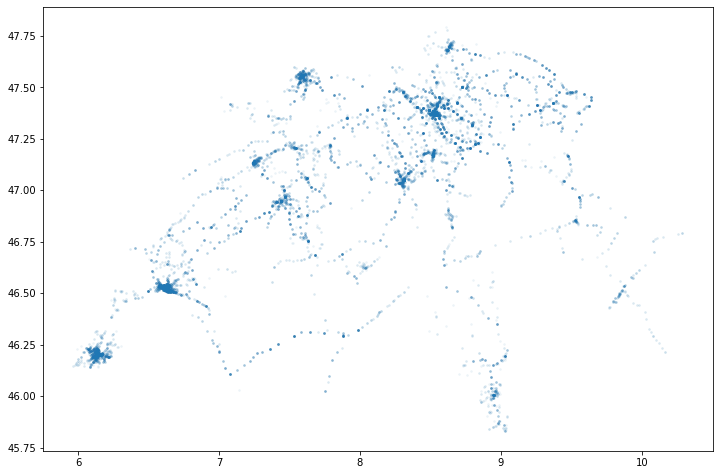

In [283]:
gdf.plot(markersize=3, alpha=0.05, figsize=(12, 12));

In [ ]:
#gdf = gdf.to_crs(epsg=21781)

In [206]:
%%time
trajectories = []
for key, values in gdf[:].groupby(['trip_id']):
    try:
        trajectory = mpd.Trajectory(values, key)
        if trajectory.df.shape[0] > 1:
            trajectories.append(trajectory)
    except:
        pass

print("Finished creating {} trajectories".format(len(trajectories)))

Finished creating 1615 trajectories
CPU times: user 2.5 s, sys: 15.8 ms, total: 2.52 s
Wall time: 2.52 s


In [207]:
#trajectory.add_speed()
trajectory.df.head()

route_id                   trip_id  start_date  \
real_datetime                                                            
2020-07-07 14:40:00  20-20-j20-1  999.TA.20-20-j20-1.285.R  2020-07-07   
2020-07-07 14:48:00  20-20-j20-1  999.TA.20-20-j20-1.285.R  2020-07-07   
2020-07-07 14:49:00  20-20-j20-1  999.TA.20-20-j20-1.285.R  2020-07-07   
2020-07-07 15:09:00  20-20-j20-1  999.TA.20-20-j20-1.285.R  2020-07-07   
2020-07-07 15:10:00  20-20-j20-1  999.TA.20-20-j20-1.285.R  2020-07-07   

                    start_time      stop_id  stop_sequence     status  \
real_datetime                                                           
2020-07-07 14:40:00   14:39:00  8505209:0:3              1  departure   
2020-07-07 14:48:00   14:39:00  8505212:0:1              2    arrival   
2020-07-07 14:49:00   14:39:00  8505212:0:1              2  departure   
2020-07-07 15:09:00   14:39:00  8505415:0:1              5    arrival   
2020-07-07 15:10:00   14:39:00  8505415:0:1              5  departure   

                                delay route_desc scheduled_time  \
real_datetime                                                     
2020-07-07 14:40:00          00:01:00     S-Bahn       14:39:00   
2020-07-07 14:48:00 -1 days +23:59:00     S-Bahn       14:49:00   
2020-07-07 14:49:00          00:00:00     S-Bahn       14:49:00   
2020-07-07 15:09:00          00:00:00     S-Bahn       15:09:00   
2020-07-07 15:10:00          00:01:00     S-Bahn       15:09:00   

                           stop_name   stop_lat  stop_lon  \
real_datetime                                               
2020-07-07 14:40:00           Biasca  46.352043  8.974179   
2020-07-07 14:48:00  Castione-Arbedo  46.223041  9.041462   
2020-07-07 14:49:00  Castione-Arbedo  46.223041  9.041462   
2020-07-07 15:09:00      S. Antonino  46.160569  8.973936   
2020-07-07 15:10:00      S. Antonino  46.160569  8.973936   

                                     geometry  
real_datetime                                  
2020-07-07 14:40:00  POINT (8.97418 46.35204)  
2020-07-07 14:48:00  POINT (9.04146 46.22304)  
2020-07-07 14:49:00  POINT (9.04146 46.22304)  
2020-07-07 15:09:00  POINT (8.97394 46.16057)  
2020-07-07 15:10:00  POINT (8.97394 46.16057)

In [208]:
traj_collection = mpd.TrajectoryCollection(trajectories)
print(traj_collection)

TrajectoryCollection with 1615 trajectories


In [256]:
#@interact(i=(0, len(trajectories) - 1))
#def plot(i=0):
#    trajectories[i].plot(column='speed', linewidth=3, capstyle='round', figsize=(9,9), legend=True);

In [257]:
@interact(i=(0, len(traj_collection.trajectories) - 1))
def plot(i=17):
    return traj_collection.trajectories[i].hvplot(line_width=5.0,
                                                  tiles='CartoDark',
                                                  c='speed',
                                                  cmap='inferno',
                                                  colorbar=True)

interactive(children=(IntSlider(value=17, description='i', max=1614), Output()), _dom_classes=('widget-interac…

In [213]:
def get_locations_at_timestamps(col, t):
    pos = []
    for traj in col.trajectories:
        if t > traj.get_start_time() and t < traj.get_end_time():
            pos.append({
                'geometry': traj.get_position_at(t),
                'id': str(traj.id)
            })
    return GeoDataFrame(pd.DataFrame(pos), crs=traj.crs)

In [253]:
def plot_locations_at_timestamps(col, t, ax=None):
    loc = get_locations_at_timestamps(col, t)
    return (loc.hvplot(c='id',
                       size=20,
                       geo=True,
                       color='white',
                       tiles='CartoDark'))

In [310]:
@interact(i=(0, 59), j=(15, 16))
def plot(i=0, j=15):
    t = datetime(2020, 7, 7, j, i)
    t = np.datetime64(t)
    #return get_locations_at_timestamps(traj_collection, t)
    moving = get_locations_at_timestamps(traj_collection, t)
    f, ax = plt.subplots(figsize=(12, 12))
    gdf.plot(ax=ax, marker='.', color='blue', markersize=3, alpha=0.05)
    moving.plot(ax=ax, marker='.', color='red', markersize=9, alpha=0.86)
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=59), IntSlider(value=15, description='j', max=16…

In [255]:
@interact(i=(0, 59, 1), j=(15, 16))
def plot(i=0, j=15):
    t = datetime(2020, 7, 7, j, i)
    t = np.datetime64(t)
    return plot_locations_at_timestamps(traj_collection, t)

interactive(children=(IntSlider(value=0, description='i', max=59), IntSlider(value=15, description='j', max=16…